# How to simulate quantum dynamics for noiseless systems using graphs
**Simulate the dynamics of closed quantum systems**

Boulder Opal enables you to simulate the dynamics of quantum systems that are subject to complex deterministic Hamiltonians. Simulation of quantum dynamics can benefit from graph-based calculation when elements of the computation undergo transformations linked to other nodes.  For instance, considering simulation of a quantum system subject to a distorted control pulse, we can combine the source of distortion into the computational graph in order to flexibly simulate the composite system.

In this notebook we show how to use Boulder Opal to perform simulations of multilevel systems with complex coupling mechanisms using graph-based simulation.  This approach is preferable when a simulation becomes part of a larger computation where flexibility is prioritized. 

## Summary workflow

Here we show how to use Boulder Opal to create and execute a graph made up of nodes (corresponding to the different steps in the simulation) that represent functions of previous nodes (or of constant values).
Please see the [currently available primitive nodes](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes.html).


### 1. Define computational graph
To describe the dynamics of a noiseless quantum system with Boulder Opal, start by setting up a graph object as described in the [How to represent quantum systems using graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs) user guide. 

### 2. Set up quantum system
Within the graph, define the piecewise-constant (PWC) system Hamiltonian. This is done by combining time-dependent signals with the corresponding operators for each term in the Hamiltonian. Signals are created using the `graph.pwc_signal` operation, while the operators are represented by constant matrices. 

### 3. Create simulation node
Define a simulation node using the `graph.time_evolution_operators_pwc` operation. This calculates the unitary operation corresponding to the evolution of the system at times defined by the array `sample_times`. From these unitaries, one can calculate the state, or any system observable, at the specified times.   

### 4. Execute graph-based simulation 
Execute the graph-based simulation by calling the `boulderopal.execute_graph` function. After the simulation is successfully completed, you can extract the results explicitly defined in the `output_node_names`, as described in the 
[How to represent quantum systems using graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs) user guide.

The graph-based approach also offers the possibility of running multiple simulations with a single call to `boulderopal.execute_graph`. For this, instead of defining a single Hamiltonian, you can define a batch of them, as examplified in the STIRAP example below. 

## Example: Generate entangled states in atomic chains

In this example we show how to simulate the adiabatic dynamics of a multi-atomic system going from the ground state to an entangled state involving all atoms.
We start by instantiating a graph and [adding operations to it](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes.html) in order to simulate the dynamics of an atomic chain.

We consider a chain of $N=8$ atoms, each one modeled as a qubit, with $|0\rangle$ representing the ground state and $|1\rangle$ representing a Rydberg state.
The total Hamiltonian of the system, as described by [A. Omran et al.](https://doi.org/10.1126/science.aax9743), is given by

$$ H = \frac{\Omega(t)}{2} \sum_{i=1}^N \sigma_x^{(i)} - \Delta(t) \sum_{i=1}^N n_i - \sum_{i=1}^N \delta_i n_i + \sum_{i<j}^N \frac{V}{\vert i-j \vert^6}n_i n_j , $$

with $\sigma_x^{(i)} = \vert 0 \rangle \langle 1 \vert_i + \vert 1 \rangle \langle 0 \vert_i$, and $n_i = \vert 1\rangle\langle 1 \vert_i$.
The fixed system parameters are the interaction strength between excited atoms, $V= 2\pi \times 24$ MHz, and the local energy shifts $\delta_i =  - 2 \pi \times 4.5$ MHz for $i=1,N$ or 0 otherwise.

We consider the system to be initially in its ground state,
$ |\psi(t=0)\rangle = |00000000\rangle$ ,
and we aim to prepare the entangled target state
$|\psi_\mathrm{target}\rangle = \frac{1}{\sqrt{2}} \Big( |01010101\rangle + |10101010\rangle \Big) $.
To achieve this superposition, the effective coupling strength to the Rydberg state $\Omega(t)$ is modulated by a $\sin^2$ envelope while the detuning $\Delta(t)$ is linearly swept around zero, for a total time of $T = 1.1$ µs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

Your task (action_id="1829145") has started.
Your task (action_id="1829145") has completed.


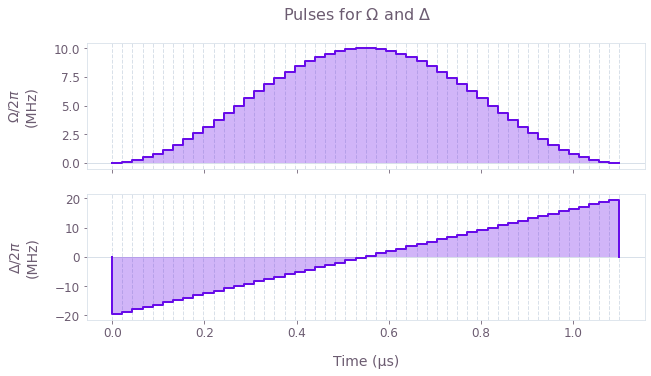

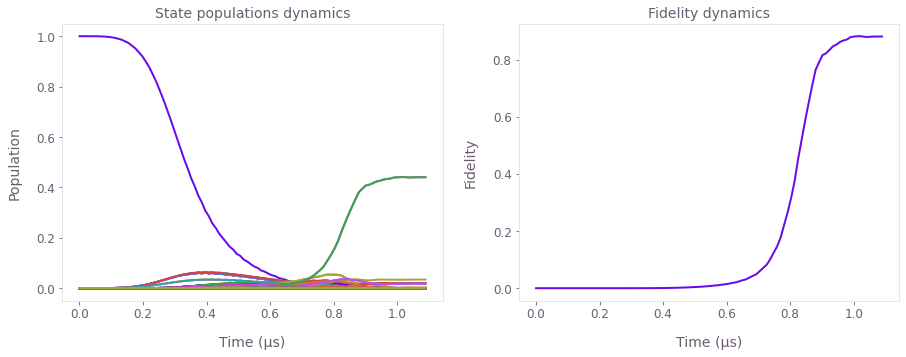

In [2]:
# Physical parameters of the systems.
N_qubits = 8
interaction_strength = 24.0e6 * (2.0 * np.pi)  # Hz
local_shift = -4.5e6 * (2.0 * np.pi)  # Hz
omega_max = 10.0e6 * (2.0 * np.pi)  # Hz
delta_max = 20.0e6 * (2.0 * np.pi)  # Hz
total_duration = 1.1e-6
segments = 50
sample_times = np.linspace(0.0, total_duration, 100, endpoint=False)

# Create the data flow graph describing the system.
graph = bo.Graph()

# Coupling strength to the Rydberg state operator.
sigma_x_sum = sum(
    graph.pauli_kronecker_product([("X", k)], N_qubits) for k in range(N_qubits)
)

# Detuning operator.
n_operator_list = [
    0.5 * graph.pauli_kronecker_product([("I", k)], N_qubits)
    - 0.5 * graph.pauli_kronecker_product([("Z", k)], N_qubits)
    for k in range(N_qubits)
]
n_operator_sum = graph.sum(n_operator_list, 0)

# Local energy shift operator.
local_shifts = np.zeros(N_qubits)
local_shifts[0] = local_shift
local_shifts[-1] = local_shift
local_shift_operator = sum(shift * n for shift, n in zip(local_shifts, n_operator_list))

# Interaction operator.
interaction_operator = 0
for idx1 in range(N_qubits):
    for idx2 in range(idx1):
        n1_n2 = n_operator_list[idx1] @ n_operator_list[idx2]
        interaction_operator += (n1_n2) / np.abs(idx1 - idx2) ** 6
interaction_operator *= interaction_strength

# Initial state.
initial_state = graph.fock_state(2**N_qubits, 0)

# Target GHZ state.
idx_even = sum(2**n for n in range(0, N_qubits, 2))  # |0101...⟩
idx_odd = sum(2**n for n in range(1, N_qubits, 2))  # |1010...⟩
GHZ_state = np.zeros([2**N_qubits])
GHZ_state[[idx_even, idx_odd]] = 1.0 / np.sqrt(2.0)

# Signals for delta and omega.
omega_signal = graph.signals.cosine_pulse_pwc(
    duration=total_duration, segment_count=segments, amplitude=omega_max, name="omega"
)
delta_signal = graph.signals.linear_ramp_pwc(
    duration=total_duration, segment_count=segments, end_value=delta_max, name="delta"
)

# Construct the Hamiltonian.
omega_term = 0.5 * omega_signal * sigma_x_sum
delta_term = -delta_signal * n_operator_sum
constant_term = interaction_operator - local_shift_operator

hamiltonian = omega_term + delta_term + constant_term

# Calculate the evolution unitaries and evolve the initial state.
unitaries = graph.time_evolution_operators_pwc(
    hamiltonian=hamiltonian, sample_times=sample_times
)
evolved_states = unitaries @ initial_state[:, None]
evolved_states.name = "evolved_states"

# Project the evolved and target states to calculate the fidelity.
fidelity = graph.abs(GHZ_state[None] @ evolved_states) ** 2
fidelity.name = "fidelity"

# Run simulation.
graph_result = bo.execute_graph(
    graph=graph, output_node_names=["omega", "delta", "evolved_states", "fidelity"]
)

# Plot the controls.
qv.plot_controls(
    {
        "$\\Omega$": graph_result["output"]["omega"],
        "$\\Delta$": graph_result["output"]["delta"],
    }
)
plt.suptitle("Pulses for $\\Omega$ and $\\Delta$")

# Retrieve and plot the evolved states and fidelity.
evolved_states = graph_result["output"]["evolved_states"]["value"].squeeze()
fidelity = graph_result["output"]["fidelity"]["value"].squeeze()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(sample_times * 1e6, np.abs(evolved_states) ** 2)
axs[0].set_xlabel("Time (µs)")
axs[0].set_ylabel("Population")
axs[0].set_title("State populations dynamics")
axs[1].plot(sample_times * 1e6, fidelity)
axs[1].set_xlabel("Time (µs)")
axs[1].set_ylabel("Fidelity")
axs[1].set_title("Fidelity dynamics")
plt.show()

## Example: Simulate the effect of pulse delay on STIRAP

In this example we show how to simulate the dynamics of a three-level system undergoing stimulated Raman adiabatic passage (STIRAP) when subjected to pump and Stokes pulses. If the pulses are applied in a counter-intuitive manner, that is, $\Omega_{23}(t)$ is applied before $\Omega_{12}(t)$ (or $t_\textrm{delay} >0$), the STIRAP pulse sequence will transfer the population in state $|1\rangle$ to state $|3\rangle$. In the calculation below, we will see the effect of $t_\textrm{delay}$ on the infidelity of the process. Moreover, we will assume that the input controls are very coarse, consisting of very few segments, but they are passed through a Gaussian filter before acting on the three-level system.


The Hamiltonian of the system is given by
$$
H(t) =
\frac{1}{2} \Omega_{12}(t) \Big(|1\rangle\langle 2| + |2\rangle\langle 1|\Big)
+
\frac{1}{2} \Omega_{23}(t) \Big(|2\rangle\langle 3| + |3\rangle\langle 2|\Big)
,
$$
where the time-dependent Rabi rates for the pump and Stoke pulses are applied for $t\in(0,T)$ with a Gaussian profile:
$$
\Omega_{12}(t) = \Omega_\max \exp\left(- \frac{\left(t - \frac{T}{2} - \frac{t_\textrm{delay}}{2}\right)^2}{2\sigma^2}\right)
\\
\Omega_{23}(t) = \Omega_\max \exp\left(- \frac{\left(t - \frac{T}{2} + \frac{t_\textrm{delay}}{2}\right)^2}{2\sigma^2}\right)
$$
with a maximum amplitude $\Omega_\max$, a pulse width $\sigma$, and a delay between them of $t_\textrm{delay}$.



In [3]:
# Define matrices for the Hamiltonian operators.
a_12 = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]])
a_23 = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]])

# Define the target unitary: state |1⟩ goes to state |3⟩.
target_operation = np.array([[0, 0, 0], [0, 0, 0], [1, 0, 0]])

# Define system parameters.
omega_max = 2 * np.pi * 5e6  # Hz
total_duration = 10.0e-6  # s
sigma = 0.5e-6
gauss_filter_std = 0.5e-6
input_segment_count = 12
filtered_segment_count = 100

times = np.linspace(0.0, total_duration, input_segment_count)
durations = np.array([total_duration / input_segment_count] * input_segment_count)

Below we create a batch of input Gaussian pulses (for different values of $t_\textrm{delay}$), filter them, and use them to simulate the time evolution of the system. The batch of pulses allows the computations for all values of $t_\textrm{delay}$ to be performed in parallel when the graph is executed. In this case, the first dimension of the $\Omega$ pulse corresponds to the number of delay values in the batch (defined as 51 here) and the second dimension accounts for the time points sampled from the evolution (defined by `input_segment_count = 12` in this example). 


In [4]:
# Define values of t_delay.
t_delay_values = np.linspace(-total_duration / 2, total_duration / 2, 51)

# Create batch of coarse input pulses.
omega_12_pulse = omega_max * np.exp(
    -0.5
    * (times[None] - total_duration / 2.0 - t_delay_values[:, None] / 2.0) ** 2
    / sigma**2
)
omega_23_pulse = omega_max * np.exp(
    -0.5
    * (times[None] - total_duration / 2.0 + t_delay_values[:, None] / 2.0) ** 2
    / sigma**2
)

In this particular example, we are interested only in the infidelities of the operation for each time delay, which can be extracted directly from the `graph.infidelity_stf` operation. 

In [5]:
# Create the data flow graph describing the system.
graph = bo.Graph()

# Create input signals.
omega_12_signal = graph.pwc_signal(
    values=omega_12_pulse, duration=total_duration, name="omega_12_signal"
)
omega_23_signal = graph.pwc_signal(
    values=omega_23_pulse, duration=total_duration, name="omega_23_signal"
)

# Filter signals through a Gaussian filter.
filtered_omega_12_signal = graph.convolve_pwc(
    omega_12_signal, graph.gaussian_convolution_kernel(gauss_filter_std)
)
filtered_omega_23_signal = graph.convolve_pwc(
    omega_23_signal, graph.gaussian_convolution_kernel(gauss_filter_std)
)

# Discretize filtered signals to output smoothed signals.
sampled_filtered_pulse_12 = graph.discretize_stf(
    stf=filtered_omega_12_signal,
    duration=total_duration,
    segment_count=filtered_segment_count,
    name="filtered_omega_12_signal",
)
sampled_filtered_pulse_23 = graph.discretize_stf(
    stf=filtered_omega_23_signal,
    duration=total_duration,
    segment_count=filtered_segment_count,
    name="filtered_omega_23_signal",
)

# Create Hamiltonian terms.
omega_12_term = filtered_omega_12_signal * a_12
omega_23_term = filtered_omega_23_signal * a_23

# Define the target operation.
target = graph.target(operator=target_operation)

# Calculate the infidelities.
infidelities = graph.infidelity_stf(
    sample_times=np.linspace(0, total_duration, filtered_segment_count),
    hamiltonian=omega_12_term + omega_23_term,
    target=target,
    name="infidelities",
)

# Run simulation.
graph_result = bo.execute_graph(
    graph=graph,
    output_node_names=[
        "infidelities",
        "omega_12_signal",
        "omega_23_signal",
        "filtered_omega_12_signal",
        "filtered_omega_23_signal",
    ],
)

Your task (action_id="1829146") has started.
Your task (action_id="1829146") has completed.


We now perform the simulation and retrieve the returned control infidelities.  We then plot both the infidelities as well as a pair of the input/filtered pulses simulated. 

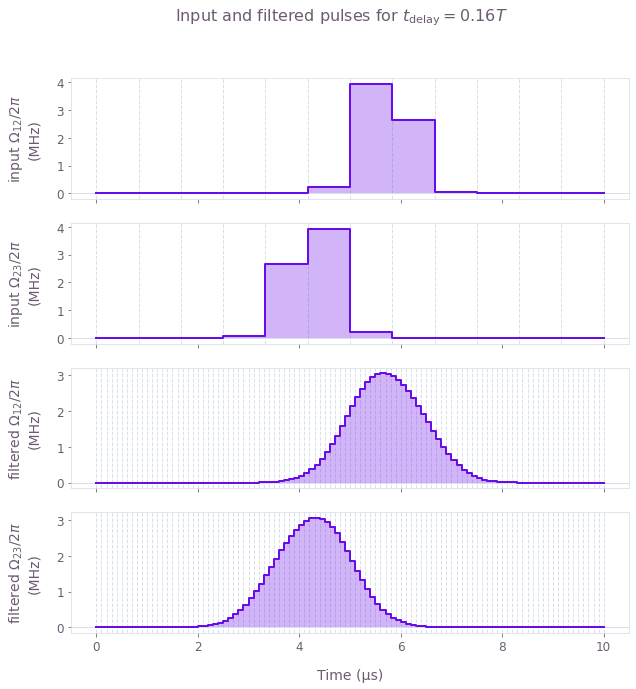

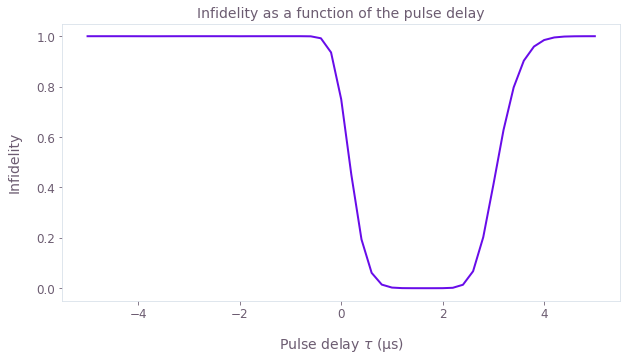

In [6]:
def batch_item(batch, idx):
    """
    Extract a single item from a batched PWC.
    """
    return {"durations": batch["durations"], "values": batch["values"][idx]}


# Plot the input/filtered pulses.
qv.plot_controls(
    {
        "input $\\Omega_{12}$": batch_item(
            graph_result["output"]["omega_12_signal"], 33
        ),
        "input $\\Omega_{23}$": batch_item(
            graph_result["output"]["omega_23_signal"], 33
        ),
        "filtered $\\Omega_{12}$": batch_item(
            graph_result["output"]["filtered_omega_12_signal"], 33
        ),
        "filtered $\\Omega_{23}$": batch_item(
            graph_result["output"]["filtered_omega_23_signal"], 33
        ),
    }
)
plt.suptitle(r"Input and filtered pulses for $t_\mathrm{delay} = 0.16 T$")

# Plot the infidelities obtained as a function of the pulse delay.
plt.figure()
plt.plot(t_delay_values / 1e-6, graph_result["output"]["infidelities"]["value"])
plt.xlabel(r"Pulse delay $\tau$ (µs)")
plt.ylabel("Infidelity")
plt.title("Infidelity as a function of the pulse delay")
plt.show()

Notice that the infidelity only goes to 0 when $t_\textrm{delay} > 0$, but if the two pulses are too separated the infidelity increases again.